# Avaliação Final



## Parte 0 - Imports

In [1]:
# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pmdarima import auto_arima
from pylab import rcParams
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [1]:
np.random.seed(0) 

NameError: name 'np' is not defined

## Parte 1 - Explorando os dados

In [4]:
df_covid_usa = pd.read_csv(
    f'./data/covid19USA.csv',
    sep = ',',
    index_col = 'date',
    parse_dates = True,
    )

df_covid_usa.head()

,confirmed,deaths
date,,
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0


In [5]:
df_covid_usa[ df_covid_usa.isna() ].count()

confirmed    0
deaths       0
dtype: int64

In [6]:
print(f'Min index: {df_covid_usa.index.min()}')
print(f'Max index: {df_covid_usa.index.max()}')
print(f'Days Between: {(df_covid_usa.index.max() - df_covid_usa.index.min()).days + 1}')
print(f'Distinct dates count: {len(df_covid_usa.index.value_counts())}')
print(f'Counts:\n{df_covid_usa.count()}')

Min index: 2020-01-01 00:00:00
Max index: 2020-09-03 00:00:00
Days Between: 247
Distinct dates count: 247
Counts:
confirmed    247
deaths       247
dtype: int64


In [7]:
df_covid_usa.sort_values(
    by = ['date']
    )

df_covid_usa = df_covid_usa.reindex(
        pd.date_range(
            start = df_covid_usa.index.min(),
            end = df_covid_usa.index.max(),
            freq = 'D'
            )
        )

df_covid_usa.fillna(
    method = 'ffill',
    inplace = True
    )

In [8]:
# Some info about this data
df_covid_usa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2020-01-01 to 2020-09-03
Freq: D
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   confirmed  247 non-null    int64
 1   deaths     247 non-null    int64
dtypes: int64(2)
memory usage: 5.8 KB


### Estatísticas gerais

In [9]:
df_covid_usa.describe().T

,count,mean,std,min,25%,50%,75%,max
confirmed,247.0,24754.680162,21935.393529,0.0,19.5,23705.0,41252.5,78427.0
deaths,247.0,752.000000,768.724934,0.0,1.0,661.0,1180.5,4928.0


No describe e info acima, é possível observar que não existem dados faltantes ou nulos, no entanto chama-se atenção para quase 5 mil mortes em um determinado ponto.<br>

Buscando sobre o assunto, em https://www.newscientist.com/article/2248813-why-are-us-coronavirus-deaths-going-down-as-covid-19-cases-soar/ e https://www.nbcnews.com/health/health-news/coronavirus-deaths-united-states-each-day-2020-n1177936 . Aparentemente neste dia, o estado de NY adicionou diversos casos retroagidos, elevando significativamente e validando esse ponto, no entanto é um outlier preocupante. O mesmo é válido para o expressivo número de casos confirmados em um dia (quase 80 mil).

### Estacionariedade da série

Testamos a estacionariedade da séries, no entanto apenas a segunda diferença está tendendo a estacionariedade.

In [10]:
# Série original
result = adfuller(
    df_covid_usa['deaths'], autolag='AIC'
    )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.389673
p-value: 0.144672
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


In [11]:
# Primeira diferença
result = adfuller(
    np.diff(df_covid_usa['deaths']), autolag='AIC'
    )

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.711535
p-value: 0.072063
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


In [12]:
# Segunda diferença
result = adfuller(
    np.diff(np.diff(df_covid_usa['deaths'])), autolag='AIC'
    )

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.463967
p-value: 0.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


### Plots

No handles with labels found to put in legend.


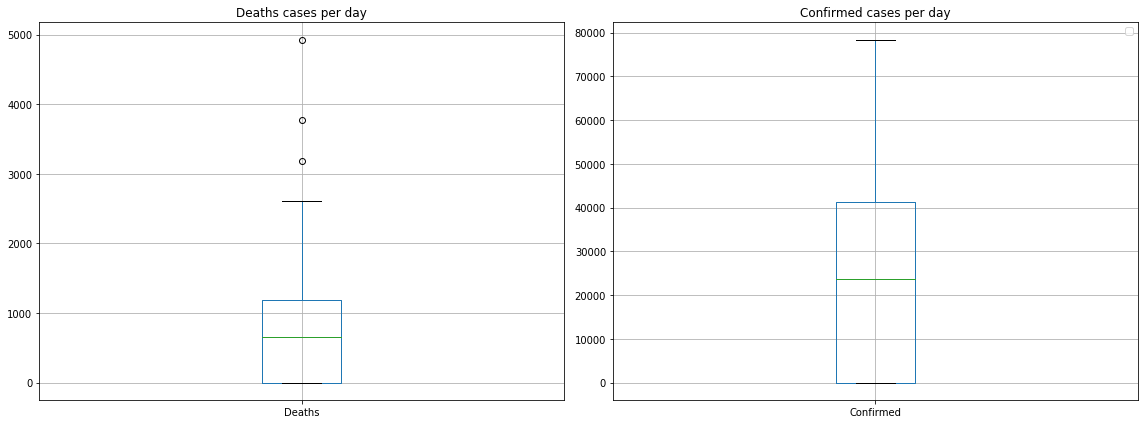

In [13]:
fig, axes = plt.subplots(
    figsize = (16,6),
    nrows = 1,
    ncols = 2
    )

df_covid_usa.plot(
    kind='box',
    y='deaths',
    label='Deaths',
    title = 'Deaths cases per day',
    ax = axes[0],
    grid = True,
    )
df_covid_usa.plot(
    kind='box',
    y='confirmed',
    label='Confirmed',
    title = 'Confirmed cases per day',
    ax = axes[1],
    grid = True,
    )

fig.tight_layout()
plt.legend(
    loc='best'
    )
plt.show()

Existem alguns outliers no boxplot de mortes, é possível que influenciem na modelagem.

Plot geral de mortes e casos confirmados, separados pois possuem escalas distintas.

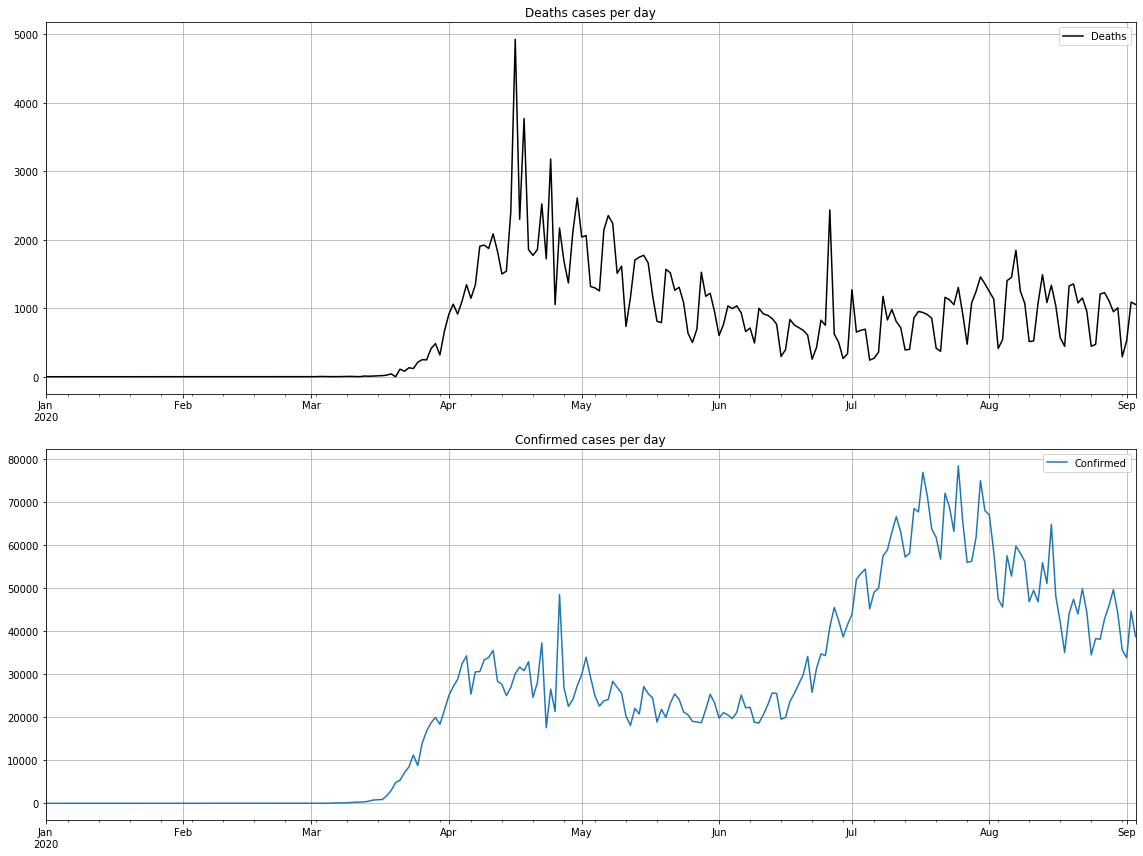

In [14]:
fig, axes = plt.subplots(
    figsize = (16,12),
    nrows = 2,
    ncols = 1
    )

df_covid_usa.plot(
    kind='line',
    y='deaths',
    label='Deaths',
    title = 'Deaths cases per day',
    ax = axes[0],
    c='black',
    grid = True,
    )
df_covid_usa.plot(
    kind='line',
    y='confirmed',
    label='Confirmed',
    title = 'Confirmed cases per day',
    ax = axes[1],
    grid = True,
    )

fig.tight_layout()
plt.legend(
    loc='best'
    )
plt.show()

Plot das funções cumulativas de mortes e casos confirmados.

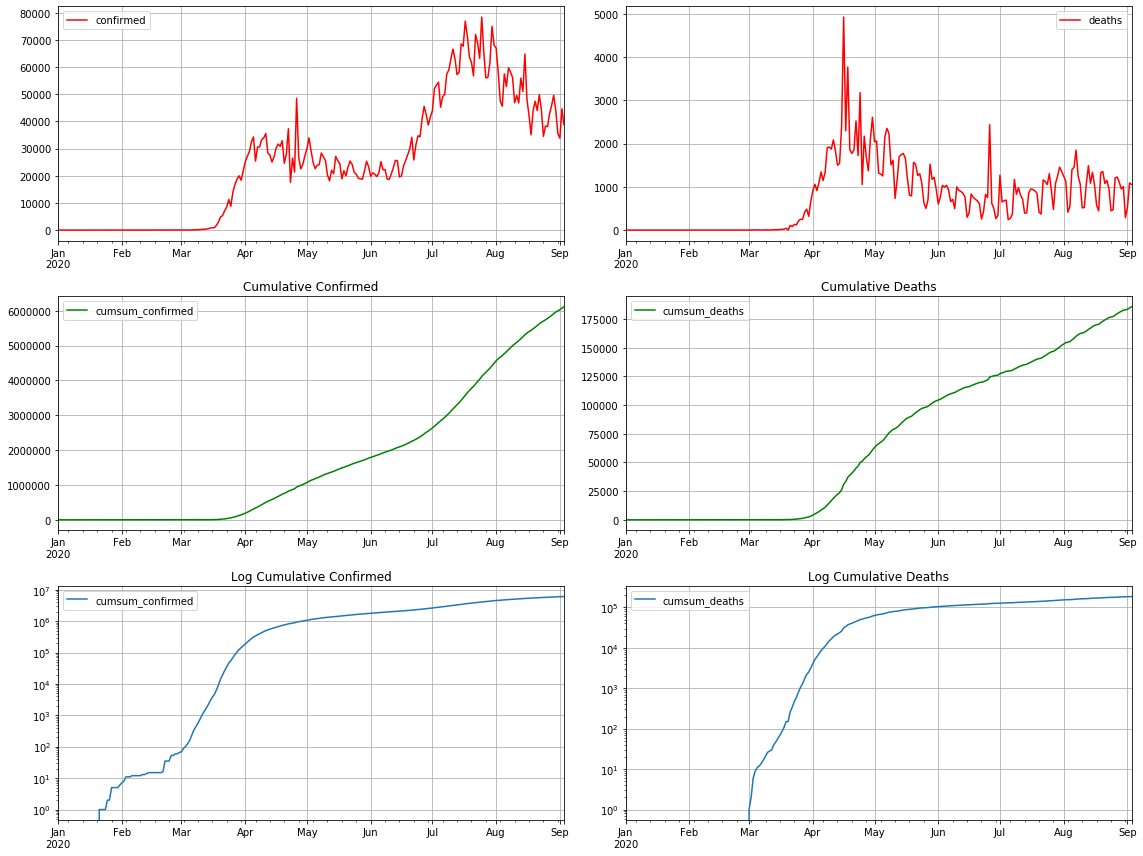

In [15]:
df_covid_usa['cumsum_confirmed'] = df_covid_usa['confirmed'].cumsum()
df_covid_usa['cumsum_deaths'] = df_covid_usa['deaths'].cumsum()

fig, axes = plt.subplots(
    figsize = (16,12),
    nrows = 3,
    ncols = 2
    )

df_covid_usa.plot(
    y = 'confirmed',
    ax = axes[0, 0],
    c = 'red',
    grid = True,
    )
df_covid_usa.plot(
    y = 'deaths',
    ax = axes[0, 1],
    c = 'red',
    grid = True,
    )
df_covid_usa.plot(
    y = 'cumsum_confirmed',
    ax = axes[1, 0],
    title = 'Cumulative Confirmed',
    c = 'green',
    grid = True,
    )
df_covid_usa.plot(
    y = 'cumsum_deaths',
    ax = axes[1, 1],
    title = 'Cumulative Deaths',
    c = 'green',
    grid = True,
    )
df_covid_usa.plot(
    y = 'cumsum_confirmed',
    ax = axes[2, 0],
    logy = True,
    title = 'Log Cumulative Confirmed',
    grid = True,
    )
df_covid_usa.plot(
    y = 'cumsum_deaths',
    ax = axes[2, 1],
    logy = True,
    title = 'Log Cumulative Deaths',
    grid = True,
    )

fig.tight_layout()
plt.legend(
    loc='best'
    )
plt.show()

## Parte 2 - Decomposição e correlação.

### Decomposição dos dados de morte em tendência e sazonalidade

#### Decomposição aditiva dos dados de morte em tendência e sazonalidade

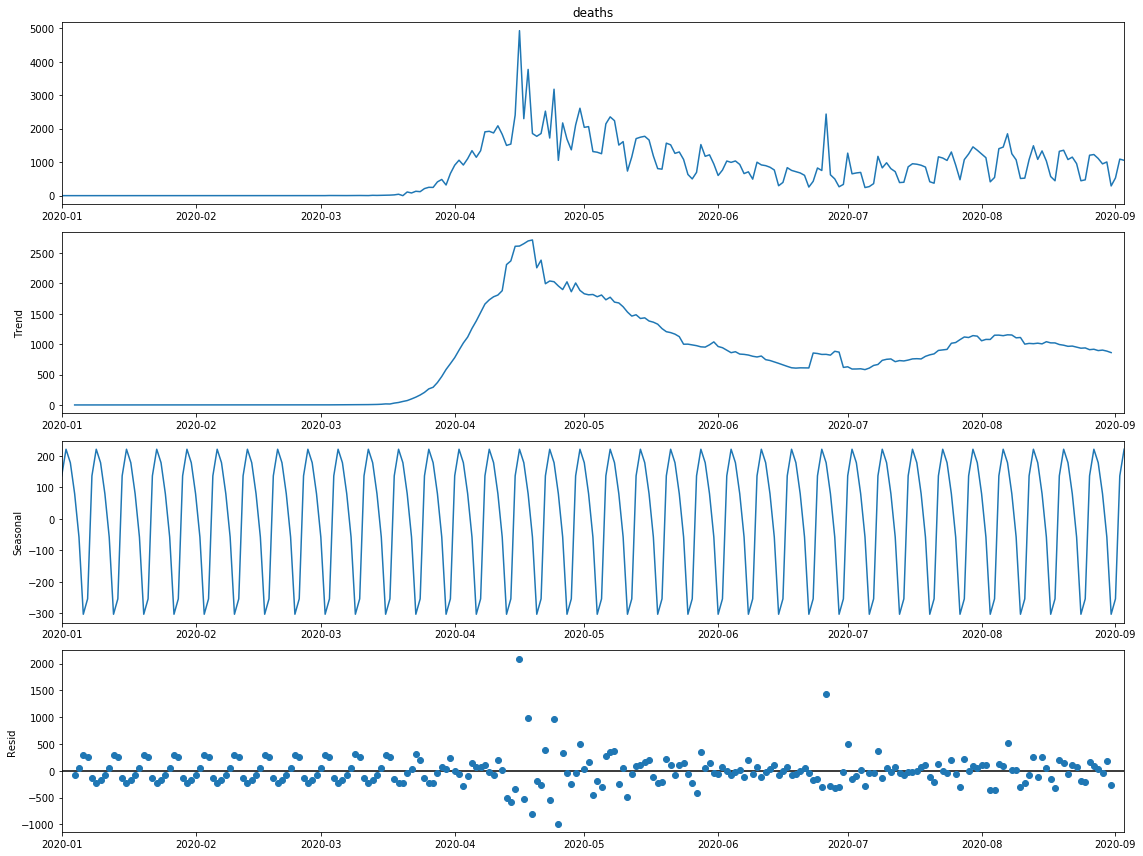

In [16]:
result = seasonal_decompose(
    df_covid_usa['deaths'],
    model = 'additive',
    period = 7
    )

rcParams['figure.figsize'] = 16, 12

_ = result.plot()

plt.show()

Não será utilizado a análise aditiva pois os resídios são muito grandes, além dos valores da sazonalidade [-300, 200], para tanto adequamos utilizando a decomposição multiplicativa, como mostrará a próxima análise.

#### Decomposição multiplicativa dos dados de morte em tendência e sazonalidade

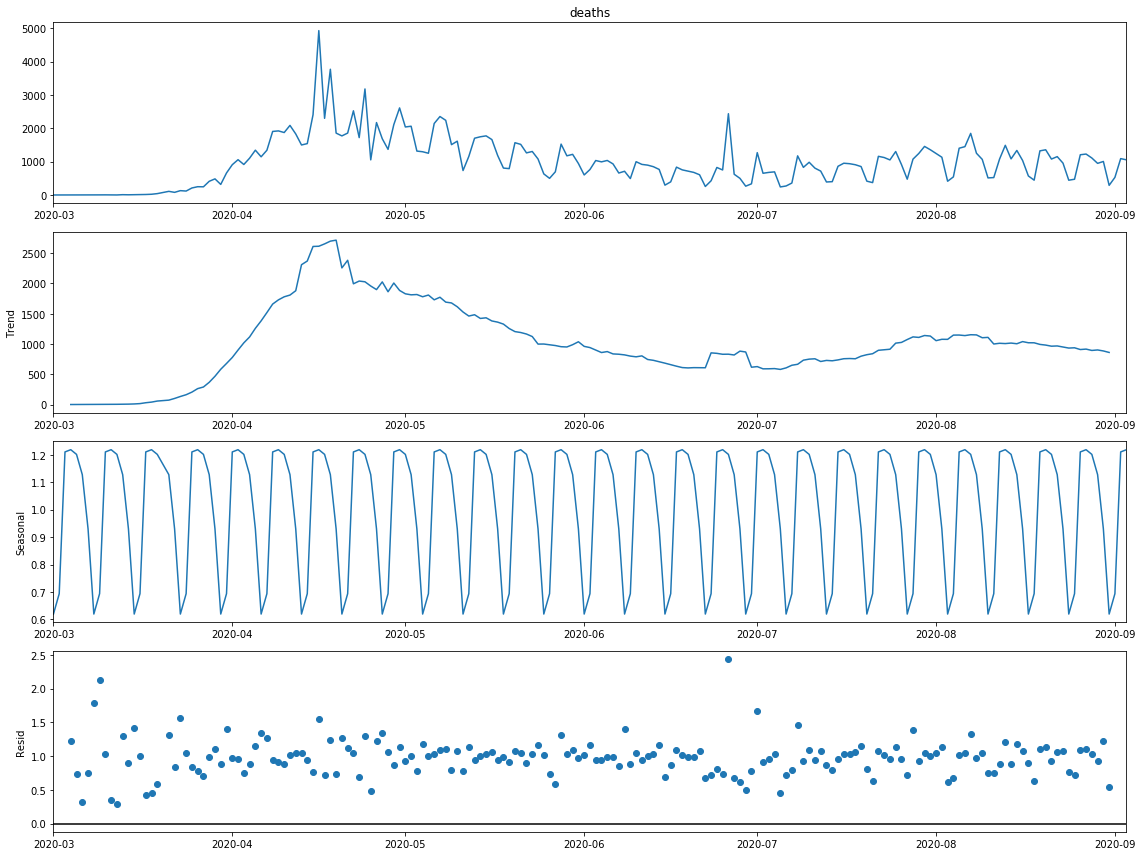

In [17]:
result = seasonal_decompose(
    df_covid_usa[df_covid_usa['deaths'] > 0]['deaths'],
    model = 'multiplicative',
    period = 7
    )

rcParams['figure.figsize'] = 16, 12

_ = result.plot()

plt.show()
plt.close()

Propomos então uma decomposição multiplicativa, pois adequa-se melhor ao problema proposto, como indica a figura abaixo onde a tendência tem picos e vales em um período próximo de 7 dias, onde o contágio foi avançado a partir do mês de março e os óbitos diários foram/vem crescendo nos EUA.
<br>
<br>
No início do ano, a tendência foi aumentando significativamente, a medida que os testes foram realizados e os óbitos confirmados, houve um declínio entre o final de abril e início de julho (porém expressivo ainda), e uma retomada no avanço dos óbitos de julho até o ínicio de setembro (último dado obsevado desta série), tudo isso alinhado a sazonalidade semanal.

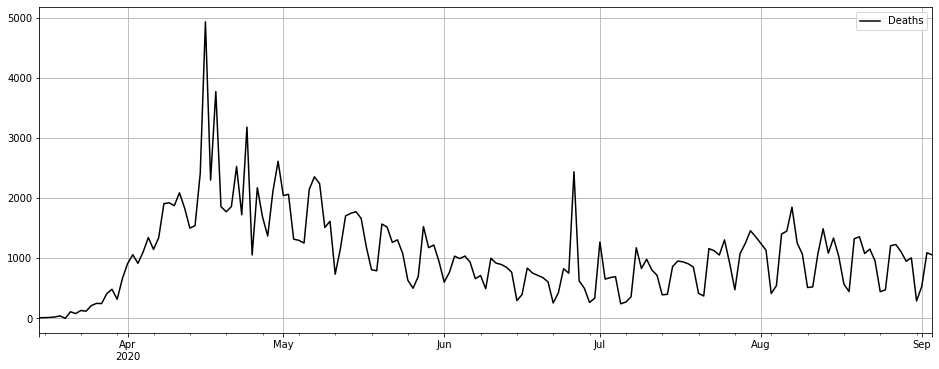

In [18]:
# Sazonalidade de aproximadamente 7 dias, com tendência, propomos a decomposição multiplicativa 
# para este caso multiplicativa em ambos: tendência e sazonalidade
df_deaths_after_april = df_covid_usa.loc['2020-03-15':]
df_deaths_after_april.plot(
    kind='line',
    y='deaths',
    label='Deaths',
    c='black',
    grid = True,
    figsize = (16,6),
    )

### Correlograma: Autocorrelação e Autocorrelação Parcial de mortes

#### Lag plot - Lags 2, 6 and 8

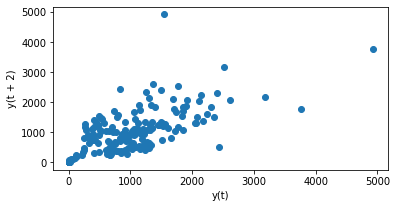

In [19]:
rcParams['figure.figsize'] = 6, 3

_ = lag_plot(
    df_covid_usa['deaths'],
    lag = 2,
    )

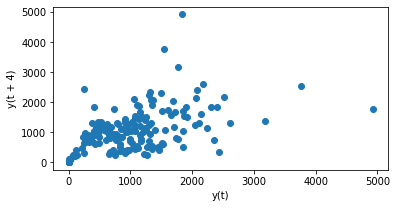

In [20]:
rcParams['figure.figsize'] = 6, 3

_ = lag_plot(
    df_covid_usa['deaths'],
    lag = 4,
    )

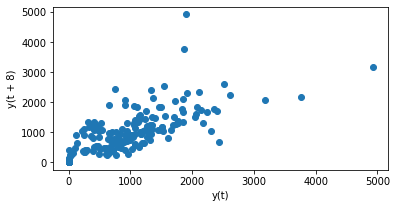

In [21]:
rcParams['figure.figsize'] = 6, 3

_ = lag_plot(
    df_covid_usa['deaths'],
    lag = 8,
    )

Nos três gráficos acima, é possível verificar uma alta correlação entre os lags 2, 4, 8.

#### Autocorrelação e Autocorrelação parcial

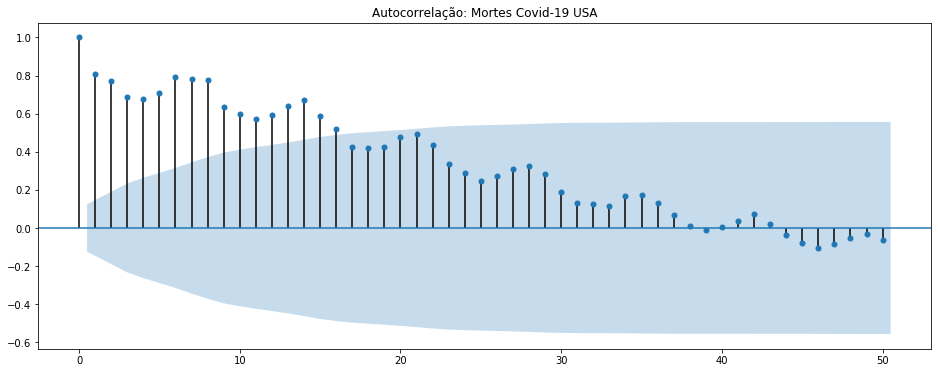

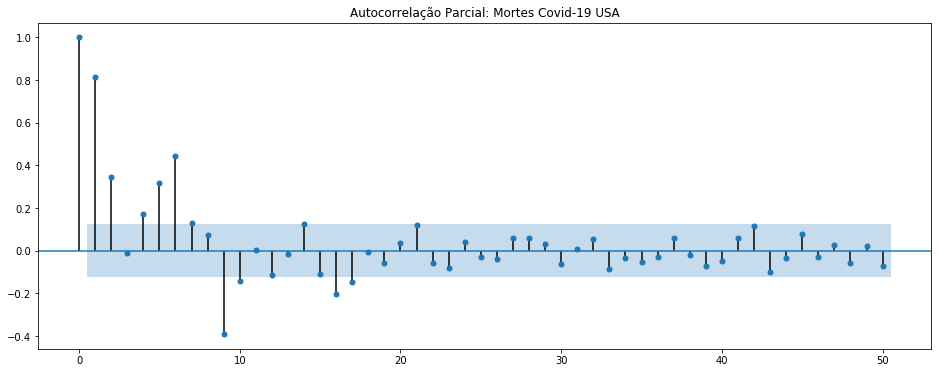

In [22]:
rcParams['figure.figsize'] = 16, 6

_ = plot_acf(
    df_covid_usa['deaths'],
    title = 'Autocorrelação: Mortes Covid-19 USA',
    lags = 50,
    )

_ = plot_pacf(
    df_covid_usa['deaths'],
    title = 'Autocorrelação Parcial: Mortes Covid-19 USA',
    lags = 50
    )

É possível observar que existe expressividade nos primeiros 16 lags, além de sazonalidade na autocorrelação, a cada 7 dias aproximadamente, não sendo estacionário.

#### Autocorrelação e Autocorrelação parcial da primeira diferença

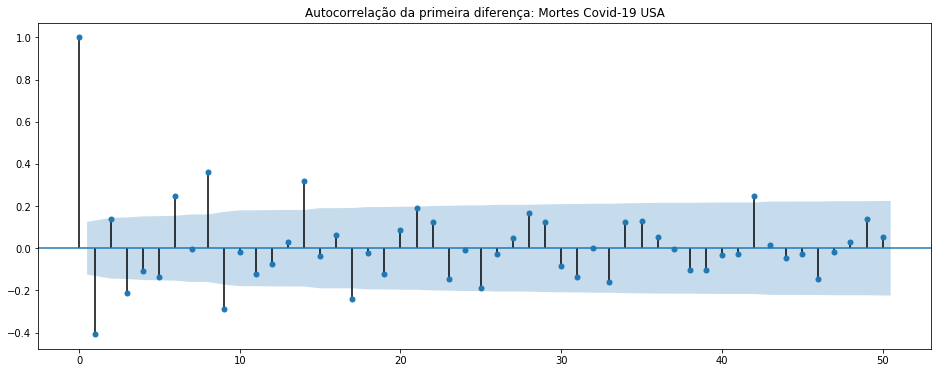

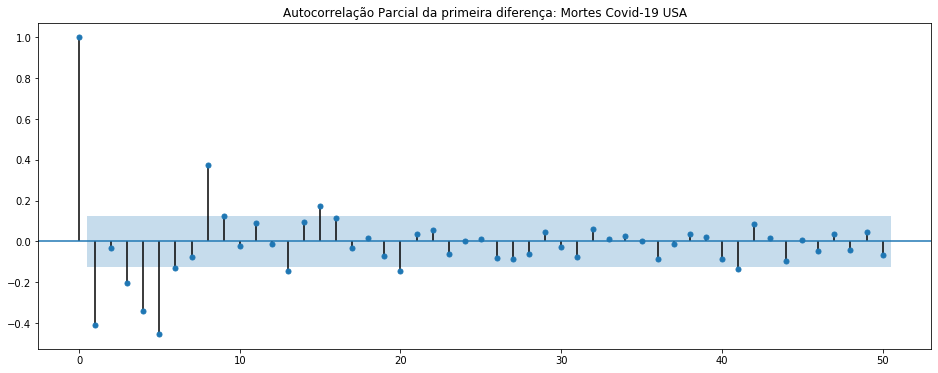

In [23]:
rcParams['figure.figsize'] = 16, 6

_ = plot_acf(
    np.diff(
        df_covid_usa['deaths']
    ),
    title = 'Autocorrelação da primeira diferença: Mortes Covid-19 USA',
    lags = 50,
    )

_ = plot_pacf(
    np.diff(
        df_covid_usa['deaths']
    ),
    title = 'Autocorrelação Parcial da primeira diferença: Mortes Covid-19 USA',
    lags = 50
    )

#### Autocorrelação e Autocorrelação parcial da segunda diferença

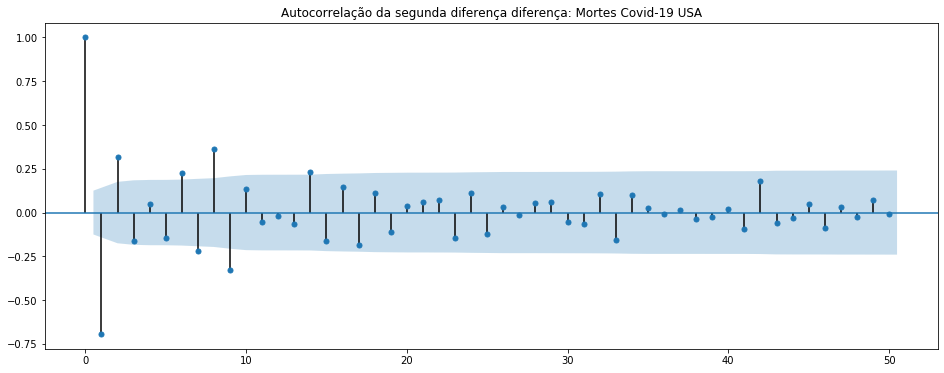

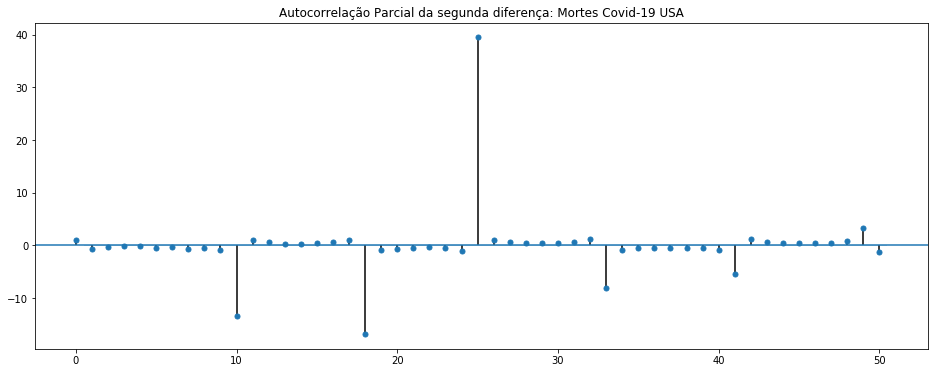

In [24]:
rcParams['figure.figsize'] = 16, 6

_ = plot_acf(
    np.diff(
        np.diff(
            df_covid_usa['deaths']
        )
    ),
    title = 'Autocorrelação da segunda diferença diferença: Mortes Covid-19 USA',
    lags = 50,
    )

_ = plot_pacf(
    np.diff(
        np.diff(
            df_covid_usa['deaths']
        )
    ),
    title = 'Autocorrelação Parcial da segunda diferença: Mortes Covid-19 USA',
    lags = 50
    )

## Parte 3 - Modelagem

### Separando as bases de treino e de teste

Dataframe que irá conter os resultados finais de todas as simulações deste notebook.

In [25]:
df_final = df_covid_usa[['deaths', 'confirmed']]

Dataframe de treino

In [26]:
df_train = df_final.iloc[ : len(df_final) - 21].drop(['confirmed'], axis=1)

Dataframe de teste

In [27]:
df_test = df_final.iloc[ -21 :].drop(['confirmed'], axis=1)

### Holt

In [28]:
# Holt only has the trend compound
holt_model = ExponentialSmoothing(
    df_train[df_train['deaths'] > 0]['deaths'],
    trend='mul'
    )\
    .fit()

predicted_holt = holt_model.forecast(21)
predicted_holt.index = pd.date_range(
    start = '2020-08-14',
    end = '2020-09-03',
    freq = 'D'
    )
predicted_holt.head()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2020-08-14    1086.449166
2020-08-15    1079.969501
2020-08-16    1073.528481
2020-08-17    1067.125876
2020-08-18    1060.761457
Freq: D, dtype: float64

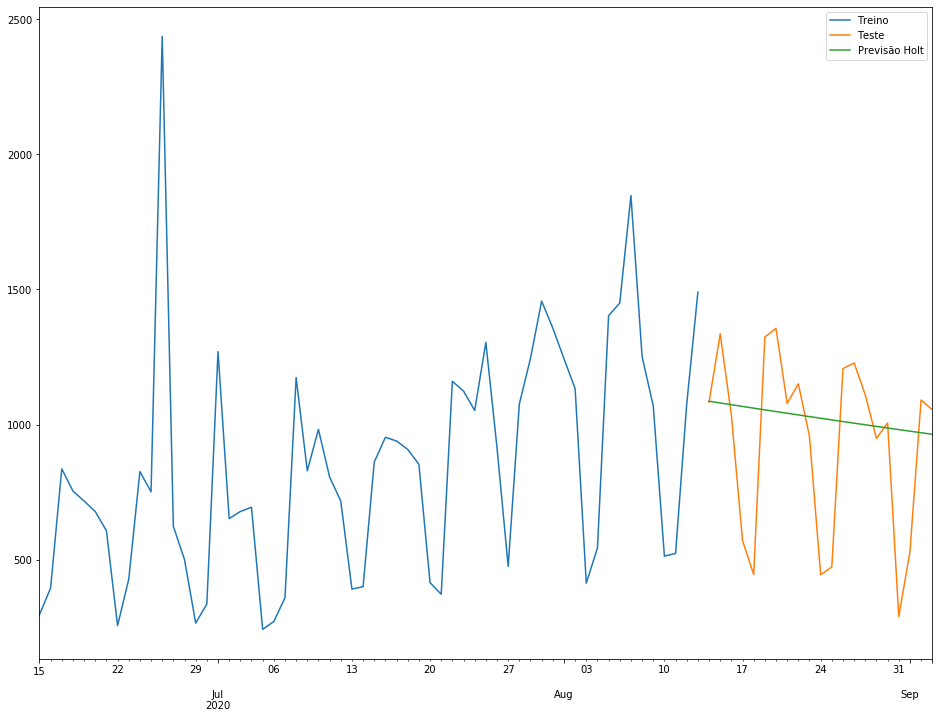

In [29]:
df_train.iloc[-60: ]['deaths'].plot(
    legend=True,
    label='Treino',
    figsize=(16, 12)
    )
df_test['deaths'].plot(
    legend=True,
    label='Teste',
    figsize=(16, 12)
    )
predicted_holt.plot(
    legend=True,
    label='Previsão Holt',
    figsize=(16, 12)
    )

### Holt Winters

In [30]:
# Holt Winters has trend and seasonal compounds
holt_winters_model = ExponentialSmoothing(
    df_train[df_train['deaths'] > 0]['deaths'],
    trend = 'mul',
    seasonal='mul',
    seasonal_periods = 7
    )\
    .fit()

predicted_holt_winters = holt_winters_model.forecast(21)
predicted_holt_winters.index = pd.date_range(
    start = '2020-08-14',
    end = '2020-09-03',
    freq = 'D'
    )
predicted_holt_winters.head()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2020-08-14    1446.308091
2020-08-15    1132.557499
2020-08-16     882.914207
2020-08-17     438.743028
2020-08-18     560.010575
Freq: D, dtype: float64

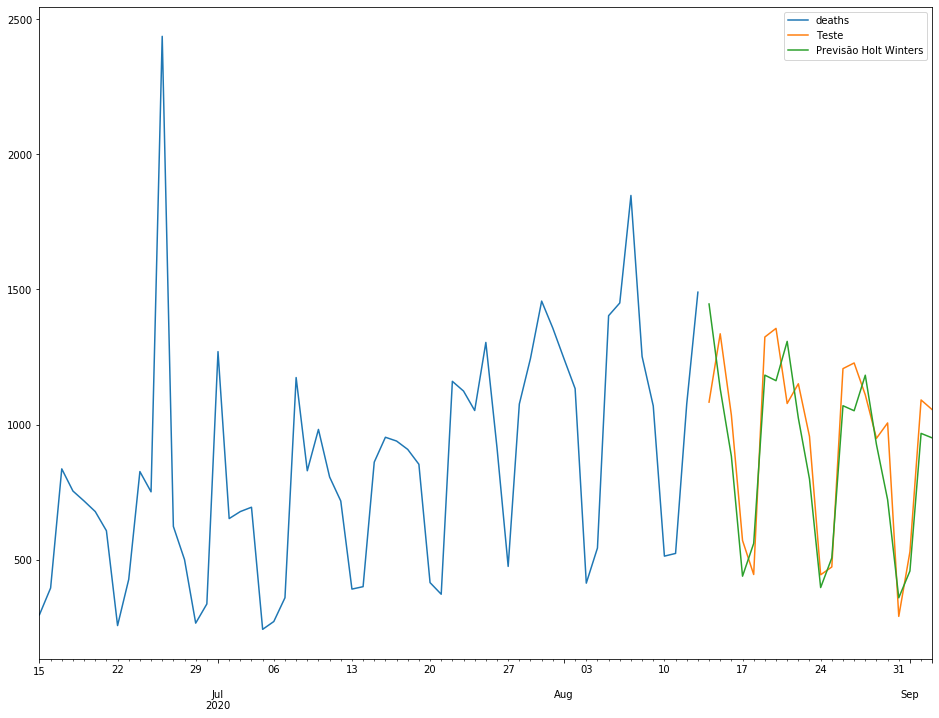

In [31]:
df_train.iloc[-60: ].plot(
    legend=True,
    label='Treino',
    figsize=(16, 12)
    )
df_test['deaths'].plot(
    legend=True,
    label='Teste',
    figsize=(16, 12)
    )
predicted_holt_winters.plot(
    legend=True,
    label='Previsão Holt Winters',
    figsize=(16, 12)
    )

### SARIMA

In [32]:
# Ajuste de modelo SARIMA
stepwise_fit = auto_arima(
    df_train['deaths'],
    start_p = 0,
    start_q = 0,
    max_p = 30,
    max_q = 30,
    max_d = 4,
    m = 7,
    seasonal = True,
    trace = True,
    error_action = 'ignore',   
    suppress_warnings = True,
    stepwise = True
    )           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=3418.337, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3418.463, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3353.998, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3349.966, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3416.508, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3359.633, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3306.510, Time=0.68 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3340.881, Time=0.26 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3303.352, Time=0.91 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3311.891, Time=0.61 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3306.292, Time=1.30 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3304.675, Time=0.97 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=3387.570, Time=0.57 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=3299.612, Time=1.10 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  226
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1626.138
Date:                           Wed, 16 Sep 2020   AIC                           3270.277
Time:                                   12:22:33   BIC                           3301.022
Sample:                                        0   HQIC                          3282.686
                                           - 226                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3169      0.091    -14.431      0.000      -1.496      -1.138
ar.L2         -0.6794      0.085     -7.981      0.000      -0.846      -0.513
ar.L3         -0.3655      0.090     -4.049      0.000      -0.542      -0.189
ar.L4         -0.4866      0.071     -6.858      0.000      -0.626      -0.348
ar.L5         -0.4032      0.047     -8.638      0.000      -0.495      -0.312
ma.L1          0.6284      0.101      6.251      0.000       0.431       0.825
ar.S.L7        0.9228      0.069     13.459      0.000       0.788       1.057
ma.S.L7       -0.7128      0.094     -7.546      0.000      -0.898      -0.528
sigma2      1.139e+05   3774.651     30.172      0.000    1.06e+05    1.21e+05
===================================================================================
Ljung-Box (Q):                       31.79   Jarque-Bera (JB):              6201.48
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):           63928.44   Skew:                             2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Utilizando o melhor modelo do processo setpwise: SARIMAX(5, 1, 1)x(1, 0, 1, 7)
<br>
Este modelo utiliza:
- Não sazonais:
    - Uma compenente auto regressiva não sazonal de ordem 5
    - Uma componente integrada não sazonal de ordem 1
    - Uma componente de média móvel não sazonal de ordem 1

- Sazonais:
    - Uma compenente auto regressiva sazonal de ordem 5
    - Uma componente integrada sazonal de ordem 0
    - Uma componente de média móvel sazonal de ordem 1
- Sazonalidade de período 7

In [33]:
sarima_model = SARIMAX(
    df_train['deaths'],
    order = (5, 1, 1),
    seasonal_order = (1, 0, 1, 7)
    )

sarima_result = sarima_model.fit()
sarima_result.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            deaths   No. Observations:                  226
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1626.138
Date:                           Wed, 16 Sep 2020   AIC                           3270.277
Time:                                   12:22:34   BIC                           3301.022
Sample:                               01-01-2020   HQIC                          3282.686
                                    - 08-13-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3169      0.091    -14.431      0.000      -1.496      -1.138
ar.L2         -0.6794      0.085     -7.981      0.000      -0.846      -0.513
ar.L3         -0.3655      0.090     -4.049      0.000      -0.542      -0.189
ar.L4         -0.4866      0.071     -6.858      0.000      -0.626      -0.348
ar.L5         -0.4032      0.047     -8.638      0.000      -0.495      -0.312
ma.L1          0.6284      0.101      6.251      0.000       0.431       0.825
ar.S.L7        0.9228      0.069     13.459      0.000       0.788       1.057
ma.S.L7       -0.7128      0.094     -7.546      0.000      -0.898      -0.528
sigma2      1.139e+05   3774.651     30.172      0.000    1.06e+05    1.21e+05
===================================================================================
Ljung-Box (Q):                       31.79   Jarque-Bera (JB):              6201.48
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):           63928.44   Skew:                             2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Obtain predicted values
inicio = df_train['deaths'].count()
fim = df_train['deaths'].count() + df_test['deaths'].count() - 1

sarima_predicted = sarima_result.predict(
    start=inicio,
    end=fim,
    dynamic=False,
    typ='levels'
    ).rename('Previsão SARIMA(5, 1, 1)x(1, 0, 1, 7)')
sarima_predicted.index = df_test.index

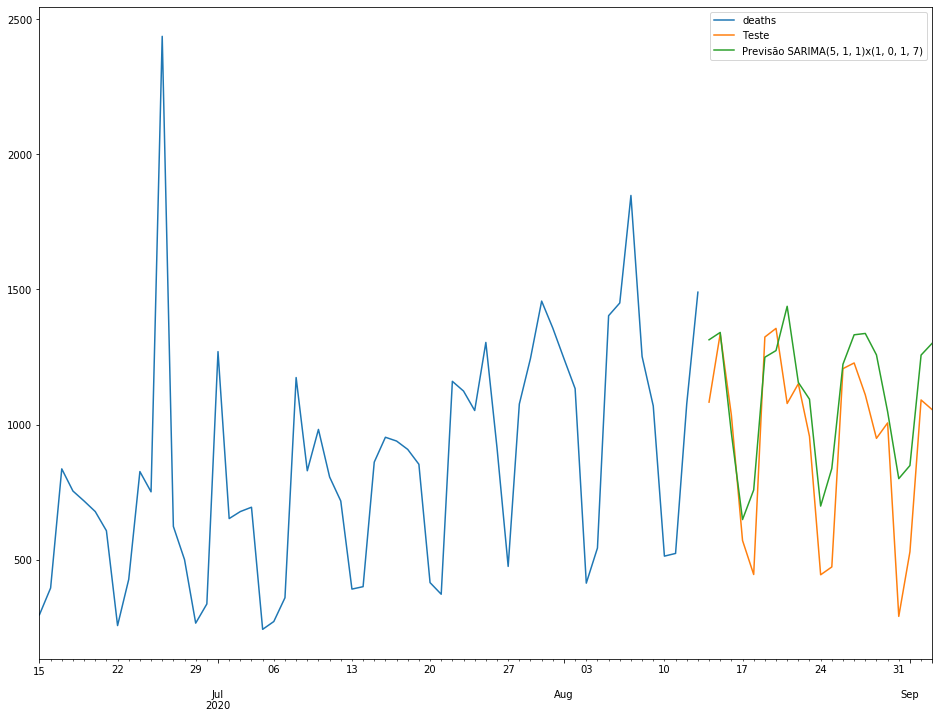

In [35]:
df_train.iloc[-60: ].plot(
    legend=True,
    label='Treino',
    figsize=(16, 12)
    )
df_test['deaths'].plot(
    legend=True,
    label='Teste',
    figsize=(16, 12)
    )
sarima_predicted.plot(
    legend=True,
    label='Previsão SARIMA(5, 1, 1)x(1, 0, 1, 7)',
    figsize=(16, 12)
    )

### Redes dinâmicas

Importante: Os dados precisam estar padronizados

In [36]:
scaler = MinMaxScaler()
scaler.fit(
    df_train
    )

MinMaxScaler(copy=True, feature_range=(0, 1))

0.0 1.0


(array([105.,  45.,  38.,  22.,  11.,   2.,   1.,   1.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

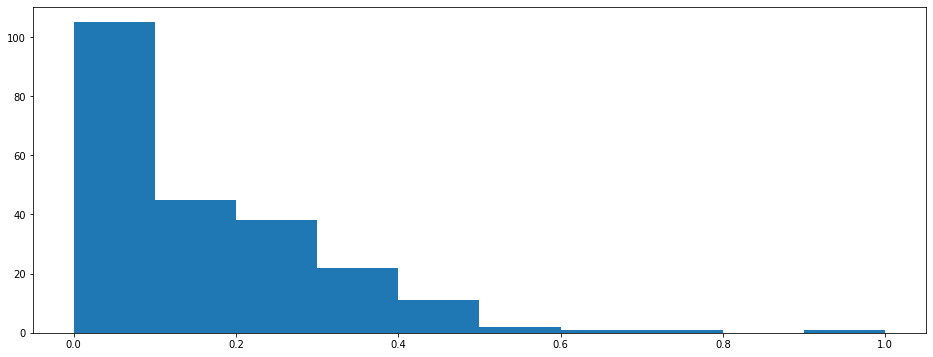

In [37]:
scaled_train = scaler.transform(
    df_train
    )

print(scaled_train.min(), scaled_train.max())
plt.hist(
    scaled_train
)

0.0588474025974026 0.27516233766233766


(array([1., 3., 2., 0., 0., 0., 4., 5., 3., 3.]),
 array([0.0588474 , 0.0804789 , 0.10211039, 0.12374188, 0.14537338,
        0.16700487, 0.18863636, 0.21026786, 0.23189935, 0.25353084,
        0.27516234]),
 <a list of 10 Patch objects>)

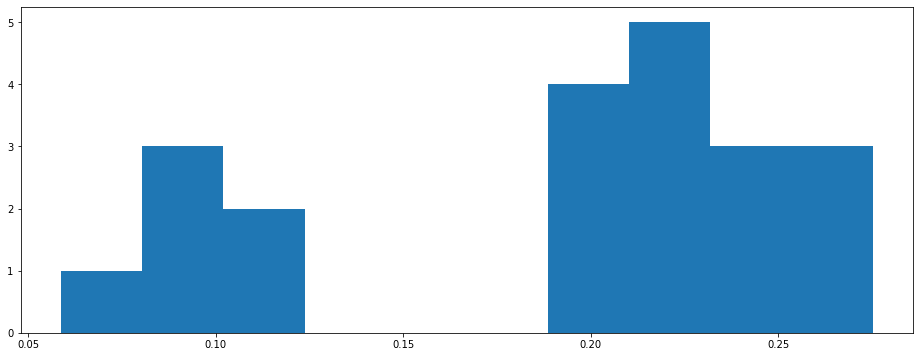

In [38]:
scaled_test = scaler.transform(
    df_test
    )

print(scaled_test.min(), scaled_test.max())
plt.hist(
    scaled_test
)

In [39]:
# defina o gerador
n_input = 7
n_features = 1
generator = TimeseriesGenerator(
    scaled_train,
    scaled_train,
    length = n_input,
    batch_size = 1
    )


In [40]:
len(scaled_train)

226

In [41]:
len(generator) # n_input = 7

219

Criando o modelo

In [42]:
# Defina o modelo
model = Sequential()

model.add(
    LSTM(
        100,
        activation='relu',
        input_shape=(n_input, n_features)
        )
    )
model.add(
    Dense(
        1
        )
    )
model.compile(
    optimizer='adam',
    loss='mse'
    )

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Ajuste do modelo
model.fit_generator(
    generator,
    epochs = 120
    )


Epoch 1/120
219/219 [==============================] - 6s 25ms/step - loss: 0.0109
Epoch 2/120
219/219 [==============================] - 4s 18ms/step - loss: 0.0084
Epoch 3/120
219/219 [==============================] - 4s 18ms/step - loss: 0.0091
Epoch 4/120
219/219 [==============================] - 4s 19ms/step - loss: 0.0078
Epoch 5/120
219/219 [==============================] - 4s 19ms/step - loss: 0.0076
Epoch 6/120
219/219 [==============================] - 4s 20ms/step - loss: 0.0078
Epoch 7/120
219/219 [==============================] - 6s 25ms/step - loss: 0.0077
Epoch 8/120
219/219 [==============================] - 5s 22ms/step - loss: 0.0074
Epoch 9/120
219/219 [==============================] - 4s 18ms/step - loss: 0.0077
Epoch 10/120
219/219 [==============================] - 4s 18ms/step - loss: 0.0070
Epoch 11/120
219/219 [==============================] - 4s 18ms/step - loss: 0.0079
Epoch 12/120
219/219 [==============================] - 4s 18ms/step - loss: 0.0073


In [45]:
model.history.history.keys()

dict_keys(['loss'])

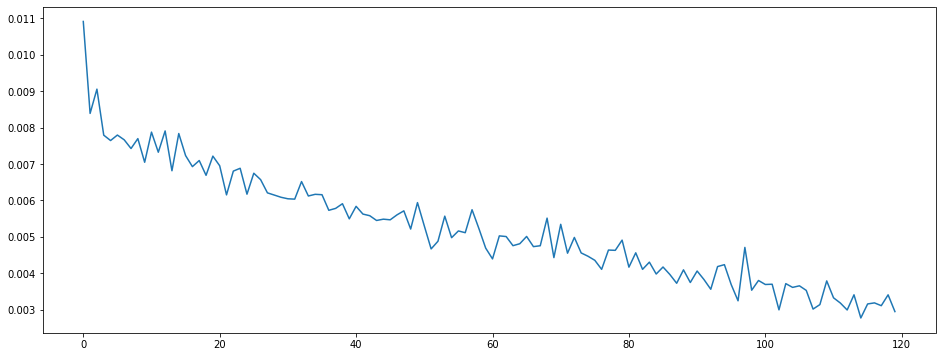

In [46]:
loss_per_epoch = model.history.history['loss']
plt.plot(
    range(
        len(loss_per_epoch)
        ),
    loss_per_epoch
    )

In [47]:
# Agora vamos considerar as previsões para as próximas 21 observações e comparar com a base de teste

test_predictions = []

first_eval_batch = scaled_train[-n_input:]

current_batch = first_eval_batch.reshape(
    (1, n_input, n_features)
    )

for i in range( df_test['deaths'].count() ):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(
        current_batch[:,1:,:],
        [[current_pred]],
        axis=1
        )


In [48]:
true_predictions = scaler.inverse_transform(
    test_predictions
    )

In [49]:
# Possivelmente encontraremos warnings aqui
df_test['Predictions'] = true_predictions

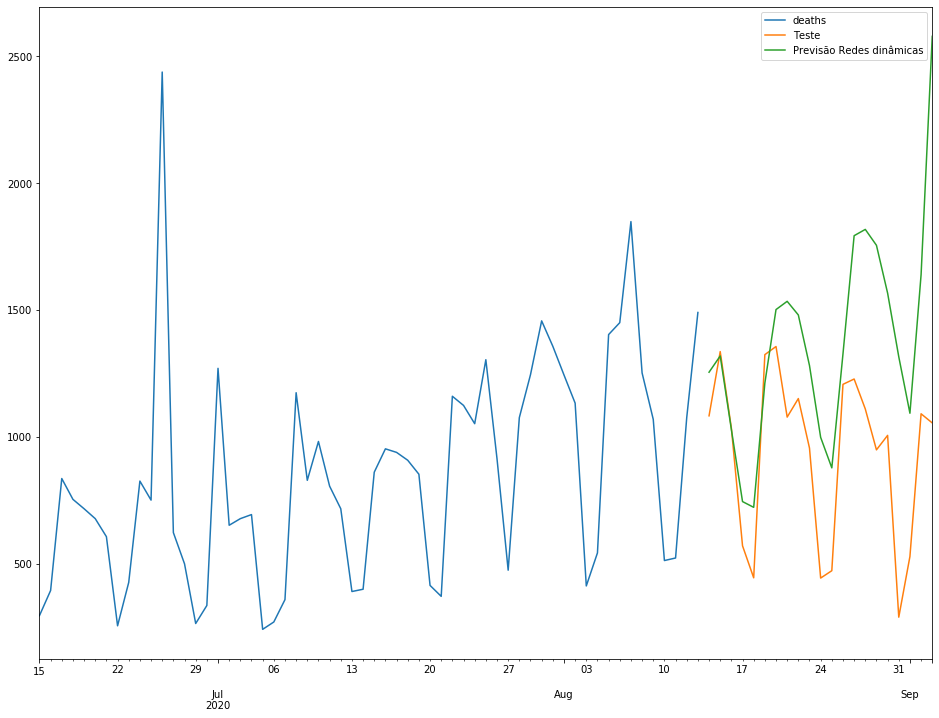

In [50]:
df_train.iloc[-60: ].plot(
    legend=True,
    label='Treino',
    figsize=(16, 12)
    )
df_test['deaths'].plot(
    legend=True,
    label='Teste',
    figsize=(16, 12)
    )
df_test['Predictions'].plot(
    legend=True,
    label='Previsão Redes dinâmicas',
    figsize=(16, 12)
    )

## Parte 4 - Erro quadrático médio e Erro quadrático absoluto

Aplico np.ceil em todos os dataframes gerados pois não existe morte "fracionada", apesar de poder arredondar para baixo, acredito que se a previsão for de 10.2 mortes, isso equivale a 11 pessoas mortas e não 10, pois uma fração deveria ser visto como um inteiro.

### Todos os modelos propostos

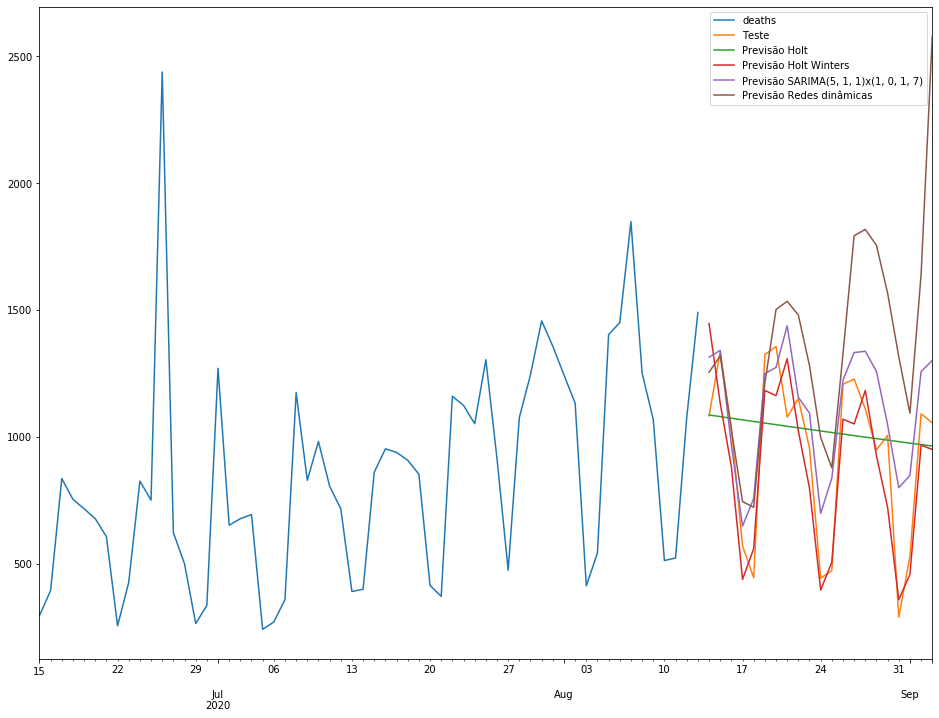

In [51]:
# Dados originais
df_train.iloc[-60: ].plot(
    legend=True,
    label='Treino',
    figsize=(16, 12)
    )
df_test['deaths'].plot(
    legend=True,
    label='Teste',
    figsize=(16, 12)
    )

# Holt
predicted_holt.plot(
    legend=True,
    label='Previsão Holt',
    figsize=(16, 12)
    )

# Holt Winters
predicted_holt_winters.plot(
    legend=True,
    label='Previsão Holt Winters',
    figsize=(16, 12)
    )

# SARIMA
sarima_predicted.plot(
    legend=True,
    label='Previsão SARIMA(5, 1, 1)x(1, 0, 1, 7)',
    figsize=(16, 12)
    )

# Redes dinâmicas
df_test['Predictions'].plot(
    legend=True,
    label='Previsão Redes dinâmicas',
    figsize=(16, 12)
    )

### Resumo dos erros

In [52]:
d = {
    'Holt':  [
        mean_squared_error(
            df_test['deaths'],
            predicted_holt.apply(np.ceil)
            ),
        mean_absolute_error(
            df_test['deaths'],
            predicted_holt.apply(np.ceil)
            )],
    'Holt Winters':  [
        mean_squared_error(
            df_test['deaths'],
            predicted_holt_winters.apply(np.ceil)
            ),
        mean_absolute_error(
            df_test['deaths'],
            predicted_holt_winters.apply(np.ceil)
            )],
    'SARIMA':  [
        mean_squared_error(
            df_test['deaths'],
            sarima_predicted.apply(np.ceil)
            ),
        mean_absolute_error(
            df_test['deaths'],
            sarima_predicted.apply(np.ceil)
            )],
    'Redes Dinâmicas': [
        mean_squared_error(
            df_test['deaths'],
            df_test['Predictions'].apply(np.ceil)
            ),
        mean_absolute_error(
            df_test['deaths'],
            df_test['Predictions'].apply(np.ceil)
            )]
    }
i = [
    'Erro quadrático médio',
    'Erro quadrático absoluto'
    ]

df = pd.DataFrame(
    data = d,
    index = i
    )

In [53]:
df.head()

,Holt,Holt Winters,SARIMA,Redes Dinâmicas
Erro quadrático médio,110329.666667,26360.476190,53946.000000,326600.952381
Erro quadrático absoluto,251.380952,140.666667,186.571429,447.619048


Portanto, podemos concluir que o modelo Holt Winters está produzindo os melhores resultados

### Salvando os dados preditos

In [54]:
df_final['label'] = 'train'
df_final['label'][-21: ] = 'test'
df_final['Holt'] = predicted_holt.apply(np.ceil).astype(int)
df_final['HoltWinters'] = predicted_holt_winters.apply(np.ceil).astype(int)
df_final['SARIMA'] = sarima_predicted.apply(np.ceil).astype(int)
df_final['RedesDinamicas'] = df_test['Predictions'].apply(np.ceil).astype(int)
df_final = df_final[
    ['deaths', 'confirmed', 'label', 'Holt', 'HoltWinters', 'SARIMA', 'RedesDinamicas']
    ]

In [55]:
df_final.tail(23)

,deaths,confirmed,label,Holt,HoltWinters,SARIMA,RedesDinamicas
2020-08-12,1076,46813,train,NaN,NaN,NaN,NaN
2020-08-13,1490,55941,train,NaN,NaN,NaN,NaN
2020-08-14,1083,51094,test,1087.0,1447.0,1314.0,1255.0
2020-08-15,1336,64838,test,1080.0,1133.0,1342.0,1319.0
2020-08-16,1035,48085,test,1074.0,883.0,969.0,1030.0
2020-08-17,571,42104,test,1068.0,439.0,649.0,746.0
2020-08-18,445,35056,test,1061.0,561.0,758.0,723.0
2020-08-19,1324,44091,test,1055.0,1183.0,1250.0,1212.0
2020-08-20,1356,47426,test,1049.0,1163.0,1274.0,1502.0
2020-08-21,1078,44005,test,1042.0,1308.0,1438.0,1534.0


Salvando os dados em ./data/output_models.csv

In [56]:
df_final.to_csv(
    './data/output_models.csv',
    index = True,
    )

## Parte 5 - Previsões futuras do melhor modelo

O melhor modelo é o de Holt Wintes com tendencia e sazonalidade multiplicativa. Agorar irei prever 14 dias no futuro, utilizando todo o dataset para treinamento.

In [57]:
# Holt Winters has trend and seasonal compounds
holt_winters_model_forecast_future = ExponentialSmoothing(
    df_final[df_final['deaths'] > 0]['deaths'],
    trend = 'mul',
    seasonal='mul',
    seasonal_periods = 7
    )\
    .fit()

holt_winters_model_forecast_future = holt_winters_model_forecast_future.forecast(14)
holt_winters_model_forecast_future.index = pd.date_range(
    start = '2020-09-04',
    end = '2020-09-17',
    freq = 'D'
    )
holt_winters_model_forecast_future.head()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2020-09-04    1042.680036
2020-09-05     951.581460
2020-09-06     800.736882
2020-09-07     348.672180
2020-09-08     440.477219
Freq: D, dtype: float64

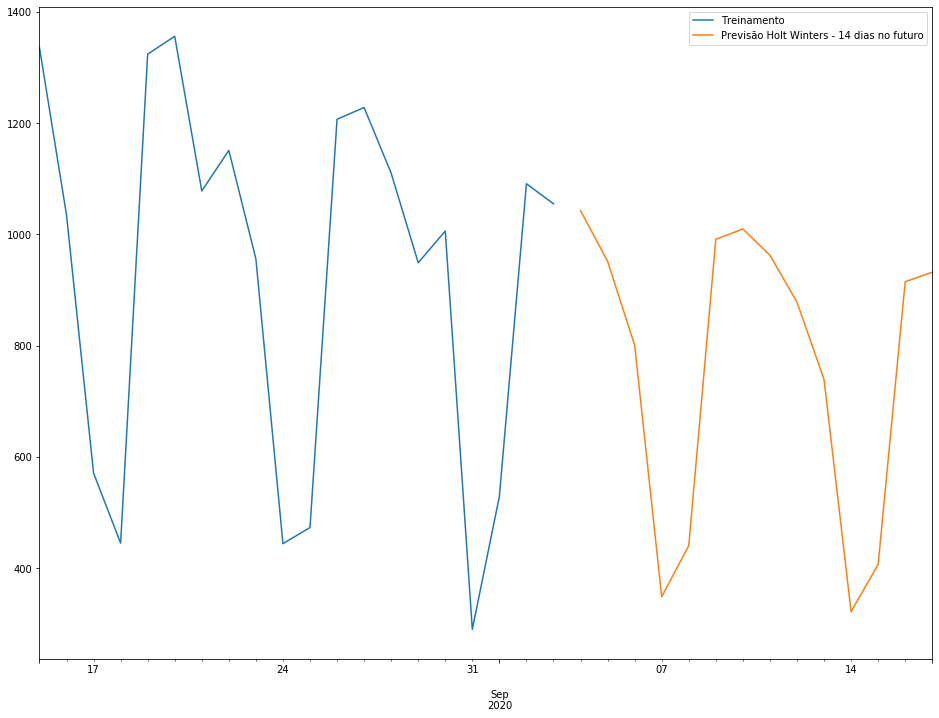

In [58]:
df_final['deaths'].iloc[-20: ].plot(
    legend=True,
    label='Treinamento',
    figsize=(16, 12)
    )
holt_winters_model_forecast_future.plot(
    legend=True,
    label='Previsão Holt Winters - 14 dias no futuro',
    figsize=(16, 12)
    )